# Constants

In [1]:
g = 9.81
# https://github.com/AadityaPatanjali/gym-cartpolemod
# magnitude of the force = 10.0
m_c  = 1.0
m_p  = 0.1
l    = 0.5
mu_c = 5e-4/4.0
mu_p = 2e-6/4.0

5.0e-7

# Cartpole

In [2]:
"""
Return the normal force of the cart on the track
"""
function N_cart( m_c, m_p, l, thetaDotDot, thetaDot, theta )
    return (m_c + m_p)*g - m_p*l*( thetaDotDot*sin(theta) + (thetaDot^2)*cos(theta) )
end

N_cart

In [3]:
"""
Return the angular acceleration of the pole
"""
function angular_accel( F, N_c, m_c, m_p, l, thetaDot, theta, xDot, mu_c, mu_p )
    
    pt1 = mu_c*sign( N_c*xDot )
    pt2 = (-F - m_p*l*(thetaDot^2)*( sin(theta) + pt1*cos(theta) ) )/(m_c + m_p) + g*pt1
    num = g*sin(theta) + cos(theta)*pt2 - ( mu_p*thetaDot )/( m_p*l )
    den = l*( 4/3 - (( m_p*cos(theta) )/( m_c + m_p ))*( cos(theta) - pt1 ) )
        
    return num / den
end

angular_accel

In [4]:
"""
Return the linear acceleration of the cart
"""
function linear_accel( F, N_c, m_c, m_p, l, thetaDotDot, thetaDot, theta, xDot, mu_c )
    return ( F + m_p*l*( (thetaDot^2)*sin(theta) - thetaDotDot*cos(theta) ) - mu_c*N_c*sign( N_c*xDot ) )/( m_c + m_p )
end

linear_accel

## Dynamics

In [5]:
"""
Calculate the next state according to "Correct equations for the dynamics of the cart-pole system"
"""
function cartpole_dyn( X, A, m_c, m_p, l, mu_c, mu_p, ts )
    
    # 1. Unpack state
    thetaDotDot = X[1] # Angular acceleration
    thetaDot    = X[2] # Angular velocity
    theta       = X[3] # Angle
    xDotDot     = X[4] # Linear acceleration
    xDot        = X[5] # Linear velocity
    x           = X[6] # Fulcrum position
    N_c         = X[7] # Normal force of the cart on the track
    
    # 2. Unpack action
    F = A
    
    # 3. Calc angular accel
    # "we may assume that N_c has the same sign as at the previous timestep and compute thetaDotDot"
    thetaDotDot_tp1 = angular_accel( F, N_c, m_c, m_p, l, thetaDot, theta, xDot, mu_c, mu_p )
    
    # 4. Calc normal force
    # "We then compute N_c using the value of thetaDotDot that we obtained"
    N_c_tp1 = N_cart( m_c, m_p, l, thetaDotDot_tp1, thetaDot, theta )
    
    # 5. "If N_c changes sign, we compute again thetaDotDot taking into account the new sign"
    if sign( N_c ) != sign( N_c_tp1 )
        thetaDotDot_tp1 = angular_accel( F, N_c_tp1, m_c, m_p, l, thetaDot, theta, xDot, mu_c, mu_p )
    end
    
    # 5. "Finally, we compute xDotDot"
    xDotDot_tp1 = linear_accel( F, N_c_tp1, m_c, m_p, l, thetaDotDot, thetaDot, theta, xDot, mu_c )
    
    # 6. Integrate angle with the trapezoid rule
    thetaDot_tp1 = thetaDot + ((thetaDotDot + thetaDotDot_tp1)/2) * ts # prev vel + change in vel
    theta_tp1    = theta    + ((thetaDot    + thetaDot_tp1   )/2) * ts # prev pos + change in pos
    
    # 6. Integrate position with the trapezoid rule
    xDot_tp1 = xDot + ((xDotDot + xDotDot_tp1)/2) * ts # prev vel + change in vel
    x_tp1    = x    + ((xDot    + xDot_tp1   )/2) * ts # prev pos + change in pos
    
    # N. Package the state vector and return it
    return [ thetaDotDot_tp1, thetaDot_tp1, theta_tp1, xDotDot_tp1, xDot_tp1, x_tp1, N_c_tp1 ]
end

cartpole_dyn

## Find state limits

In [22]:
ts   = 0.01
T    = Int64((1/ts)*10)
N_0  = N_cart( m_c, m_p, l, 0.0, 0.0, pi/2.0 )
println( N_0 )
#      [ thetaDotDot_tp1, thetaDot_tp1, theta_tp1, xDotDot_tp1, xDot_tp1, x_tp1, N_c_tp1 ]
X_0  = [ 0.0            , 0.0         , pi       , 0.0        , 0.0     , 5.0  , N_0     ]
data = zeros( size( X_0, 1 ), T )
X    = X_0

Xmax = fill( -100, size( X_0, 1 ) )
Xmin = fill(  100, size( X_0, 1 ) )


for period in [ 0.25, 0.5, 1.0, 2.0, 4.0 ]
    for j = 2:T
        t  = (j-1)*ts
        
        # A  = 10 * cos( (t/2.0)*2*pi )
        A  = -10 * cos( (t/period)*2*pi )

        Xp = cartpole_dyn( X, A, m_c, m_p, l, mu_c, mu_p, ts )
        data[:,j] = Xp 
        X = Xp
    end
    
    vMax, _ = findmax( data, dims=2 )
    vMin, _ = findmin( data, dims=2 )
    
    Xmax, _ = findmax( hcat(Xmax, vMax), dims=2 )
    Xmin, _ = findmin( hcat(Xmin, vMin), dims=2 )
end

size( data )
println( "Min Values" )
display( Xmin )
println( "Max Values" )
display( Xmax )

10.791000000000002
Min Values


7×1 Matrix{Float64}:
 -22.15656519151358
  -9.063020754639664
 -12.086987570804155
 -11.108003206256816
  -5.4987208613105105
   0.0
   0.0

Max Values


7×1 Matrix{Float64}:
 22.49031592379473
  8.123864384688932
  5.063105412854989
 11.338553649280124
  6.40155439985091
 15.415417277695173
 14.815583010848368

┌ Info: Frames for animation "test" are being stored in directory: 
│ 	 /tmp/jl_hGpYDp
└ @ Luxor /home/james/.julia/packages/Luxor/HNu4m/src/animate.jl:195
┌ Info: ... 334 frames saved in directory:
│ 	 /tmp/jl_hGpYDp
└ @ Luxor /home/james/.julia/packages/Luxor/HNu4m/src/animate.jl:217
┌ Info: GIF is: /tmp/jl_hGpYDp/test.gif
└ @ Luxor /home/james/.julia/packages/Luxor/HNu4m/src/animate.jl:246


Luxor.AnimatedGif("/tmp/jl_hGpYDp/test.gif")
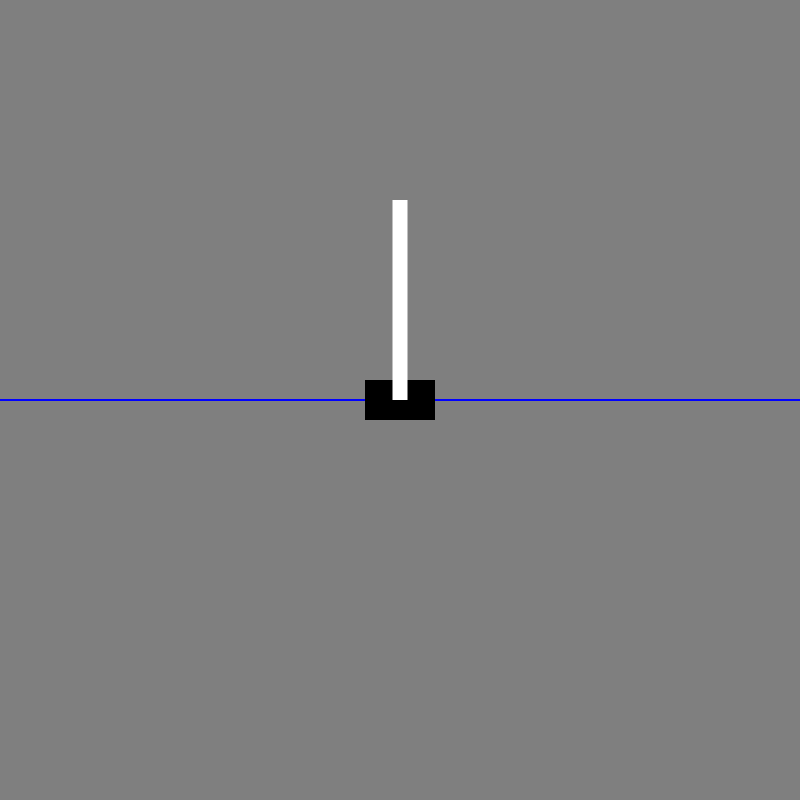

In [21]:
using Luxor

FPS  = 30
skip = Int64( floor((1/FPS)/ts) )
frms = Int64( ceil(T/skip) )

function backdrop(scene, framenumber)
    background("grey50")
end


function frame( scene, framenumber )
    
    theta = data[3,(framenumber-1)*skip+1]
    x     = data[6,(framenumber-1)*skip+1] * 20.0
    
    
    # Track
    sethue("blue")
    rule(Point(0, 0), 0.0)
    
    # Cart
    sethue("black")
    box(Point(x, 0), 70,  40, action = :fill)
    
    # Pole
    sethue("white")
    translate( x, 0 )
    translate( @polar (-100, theta+pi/2.0) )
    rotate( theta )
    box(Point(0, 0), 15, 200, action=:fill)

end


demo = Movie(800, 800, "test")

animate( demo, [
    Scene(demo, backdrop, 1:frms),
    Scene(demo, frame, 1:frms)
], creategif=true)

In [8]:
sin( 5*pi/4 )

-0.7071067811865475

# Furota Pendulum